# Prepare (Glass + Gunshot) / 准备（玻璃+枪声）

Load multi-source meta, clean and resample all audio to 22.05k mono, then proceed to folds, analysis, and window planning. 读取多源 meta，清洗后重采样为22.05k单声道，继续分折、分析与分窗规划。

## Imports / 导入

In [1]:
import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
from IPython.display import Audio, display
from src.meta_utils import load_meta_files, map_canonical_labels, deduplicate_meta, sample_gunshot_even, stratified_folds
from src.viz import plot_wave_and_mel
from src.cache_utils import build_cache_index, GLASS_PIPELINE_PLAN
from src.datasets import balance_folds
from src.augment_pipeline import run_pipeline, PIPELINE_REGISTRY
from src.data_utils import load_audio, generate_aligned_windows, trim_silence, log_mel_spectrogram
from src.config import TARGET_LABELS, POSITIVE_LABELS, SEED, SR, PROJECT_ROOT, N_MELS, HOP_LENGTH, BACKGROUND_LABEL, CACHE_ROOT, CACHE_MEL64, META_FILES, RAW_AUDIO_ROOTS, WINDOW_PARAMS


## Config Override / 配置覆写
Set parameters for this run; defaults can move into config later. 设定本次流程参数，后续可移入 config 默认。

In [2]:
META_FILES = META_FILES  # from config
LABEL_MAP = POSITIVE_LABELS
K_FOLDS = 5
RATIOS = {'glass': 3, 'gunshot': 3, 'background': 4}
MAX_DURATION = 6.0  # seconds
GUNSHOT_TARGET = 50  # total gunshot clips after sampling
TARGET_SR = SR
RESAMPLED_ROOT = CACHE_ROOT / 'data_resampled'
INCLUDE_SOURCES = ['esc50', 'gunshot_kaggle']

## Load, map, dedup / 读取映射去重
- Load meta CSVs
- Map raw labels to canonical labels
- Deduplicate by md5/filepath
- Summary counts

读取 meta，映射标签，按 md5/路径去重，打印汇总。

In [3]:
meta_df = load_meta_files(META_FILES)
meta_df = map_canonical_labels(meta_df, label_map=LABEL_MAP, target_labels=TARGET_LABELS)
meta_df = deduplicate_meta(meta_df, subset=['md5','filepath'])
print('Total rows after dedup:', len(meta_df))
print('By source (all):', meta_df['source'].value_counts().to_dict(),'\n')

INCLUDE_SOURCES = ['esc50', 'gunshot_kaggle']
working_df = meta_df[meta_df['source'].isin(INCLUDE_SOURCES)].copy()
holdout_df = meta_df[~meta_df['source'].isin(INCLUDE_SOURCES)].copy()
print('Working sources:', INCLUDE_SOURCES, '->', working_df['source'].value_counts().to_dict())
print('Working labels:', working_df['canonical_label'].value_counts().to_dict())
print('Holdout sources:', holdout_df['source'].value_counts().to_dict())
print('Holdout labels:', holdout_df['canonical_label'].value_counts().to_dict())


Total rows after dedup: 2870
By source (all): {'esc50': 2000, 'gunshot_kaggle': 851, 'freesound': 19} 

Working sources: ['esc50', 'gunshot_kaggle'] -> {'esc50': 2000, 'gunshot_kaggle': 851}
Working labels: {'gunshot': 851, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 

## Filter & gunshot sampling / 过滤与枪声抽样
- Drop clips longer than MAX_DURATION
- Evenly sample gunshot across weapon_id to total GUNSHOT_TARGET

过滤 >MAX_DURATION；枪声按 weapon_id 均匀抽样，总数 GUNSHOT_TARGET。

In [4]:
clean_df = working_df[working_df['duration_sec'] <= MAX_DURATION].copy()
gun_sampled = sample_gunshot_even(clean_df, target_label='gunshot', total=GUNSHOT_TARGET, seed=SEED)
if not gun_sampled.empty:
    gun_stats = gun_sampled.groupby('source').size().to_dict()
    weapon_stats = gun_sampled.apply(lambda r: Path(str(r.get('filepath',''))).parent.name, axis=1).value_counts().to_dict()
    print('Gunshot sampled per source:', gun_stats)
    print('Gunshot sampled per weapon_id (from parent folder):', weapon_stats, '\n')
    
non_gun = clean_df[clean_df['canonical_label'] != 'gunshot']
clean_df = pd.concat([non_gun, gun_sampled], ignore_index=True)
print(f'Label counts: （{len(clean_df)})', clean_df['canonical_label'].value_counts().to_dict())



Gunshot sampled per source: {'gunshot_kaggle': 50}
Gunshot sampled per weapon_id (from parent folder): {'AK-12': 6, 'AK-47': 6, 'M16': 6, 'MG-42': 6, 'MP5': 6, 'IMI Desert Eagle': 5, 'M249': 5, 'M4': 5, 'Zastava M92': 5} 

Label counts: （2050) {'gunshot': 50, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing

## Resample to 22.05k mono / 重采样为22.05k单声道
Write resampled audio to cache/data_resampled and build resampled_df. 将重采样音频写到 cache/data_resampled，并生成 resampled_df。
⚠️ Loads & writes all clips; may take time/disk. 需加载并写出全部音频，耗时且占用磁盘。

In [5]:
RESAMPLED_ROOT = RESAMPLED_ROOT
resampled_rows = []
for _, r in clean_df.iterrows():
    y_rs, sr_rs = load_audio(r, sr=TARGET_SR)
    rel = Path(r['filepath'])
    if rel.is_absolute():
        rel = rel.relative_to(PROJECT_ROOT)
    dst_path = RESAMPLED_ROOT / rel
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    y_int16 = (y_rs * 32767).clip(-32768, 32767).astype('int16')
    with wave.open(dst_path.as_posix(), 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(TARGET_SR)
        wf.writeframes(y_int16.tobytes())
    frames = len(y_int16)
    resampled_rows.append({
        'sno': r.get('sno', len(resampled_rows)+1),
        'raw_filepath': rel.as_posix(),
        'filepath': dst_path.relative_to(PROJECT_ROOT).as_posix(),
        'label': r.get('label'),
        'canonical_label': r.get('canonical_label'),
        'source': r.get('source'),
        'fold_id': r.get('fold_id',''),
        'duration_sec': round(frames / TARGET_SR, 3),
        'duration_samples': frames,
        'sr': TARGET_SR,
        'channels': 1,
        'bit_depth': 16,
        'md5': '',
        'extra_meta': r.get('extra_meta',''),
    })
resampled_df = pd.DataFrame(resampled_rows)
resampled_df['target_label'] = resampled_df['canonical_label']
print('Resampled rows:', len(resampled_df))
print('sr/ch after resample:', resampled_df['sr'].unique(), resampled_df['channels'].unique())
print('Label counts:', resampled_df['target_label'].value_counts().to_dict())


Resampled rows: 2050
sr/ch after resample: [22050] [1]
Label counts: {'gunshot': 50, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'crackling_fire': 40}


In [6]:
# # Optional: save holdout meta for later use
# if len(holdout_df) > 0:
#     holdout_path = RESAMPLED_ROOT / 'holdout_meta.csv'
#     holdout_path.parent.mkdir(parents=True, exist_ok=True)
#     holdout_df.to_csv(holdout_path, index=False)
#     print('Saved holdout meta to', holdout_path)


## Listen: before vs after / 试听前后
Play original vs resampled audio for a few samples. 对比播放原始与重采样音频。

In [7]:
samples = resampled_df.sample(n=min(5, len(resampled_df)), random_state=SEED)
for _, r in samples.iterrows():
    y_after, sr_after = load_audio(r, sr=TARGET_SR)
    raw_rel = Path(r.get('raw_filepath', r['filepath']))
    raw_path = PROJECT_ROOT / raw_rel if not raw_rel.is_absolute() else raw_rel
    y_before, sr_before = (None, None)
    if raw_path.exists():
        y_before, sr_before = load_audio({'filepath': raw_path}, sr=None)
    print('Sample:', r.get('target_label',''), '|', raw_rel)
    if y_before is not None:
        display(Audio(y_before, rate=sr_before))
    display(Audio(y_after, rate=sr_after))
    print('-'*40)


Sample: crow | data/esc50/audio/5-213836-B-9.wav


----------------------------------------
Sample: siren | data/esc50/audio/2-70052-B-42.wav


----------------------------------------
Sample: snoring | data/esc50/audio/3-130998-A-28.wav


----------------------------------------
Sample: sneezing | data/esc50/audio/2-130978-A-21.wav


----------------------------------------
Sample: sea_waves | data/esc50/audio/5-219379-B-11.wav


----------------------------------------


folded_df = stratified_folds(resampled_df, k=K_FOLDS, seed=SEED, group_key='canonical_label', sub_key=None, fold_column='fold_id')
print('Fold distribution (counts):', folded_df['fold_id'].value_counts().to_dict())
fold_pivot = folded_df.pivot_table(index='target_label', columns='fold_id', values='filepath', aggfunc='count').fillna(0).astype(int)
print('Label x fold (counts):')
print(fold_pivot.to_string())


In [8]:
folded_df = stratified_folds(resampled_df, k=K_FOLDS, seed=SEED, group_key='canonical_label', sub_key=None, fold_column='fold_id')
print('Fold distribution (counts):', folded_df['fold_id'].value_counts().to_dict())
fold_pivot = folded_df.pivot_table(index='target_label', columns='fold_id', values='filepath', aggfunc='count').fillna(0).astype(int)
print('Label x fold (counts):')
display(fold_pivot)

Fold distribution (counts): {1: 410, 2: 410, 3: 410, 4: 410, 5: 410}
Label x fold (counts):


fold_id            1   2   3   4   5
target_label                        
airplane           8   8   8   8   8
breathing          8   8   8   8   8
brushing_teeth     8   8   8   8   8
can_opening        8   8   8   8   8
car_horn           8   8   8   8   8
cat                8   8   8   8   8
chainsaw           8   8   8   8   8
chirping_birds     8   8   8   8   8
church_bells       8   8   8   8   8
clapping           8   8   8   8   8
clock_alarm        8   8   8   8   8
clock_tick         8   8   8   8   8
coughing           8   8   8   8   8
cow                8   8   8   8   8
crackling_fire     8   8   8   8   8
crickets           8   8   8   8   8
crow               8   8   8   8   8
crying_baby        8   8   8   8   8
dog                8   8   8   8   8
door_wood_creaks   8   8   8   8   8
door_wood_knock    8   8   8   8   8
drinking_sipping   8   8   8   8   8
engine             8   8   8   8   8
fireworks          8   8   8   8   8
footsteps          8   8   8   8   8
frog               8   8   8   8   8
glass              8   8   8   8   8
gunshot           10  10  10  10  10
hand_saw           8   8   8   8   8
helicopter         8   8   8   8   8
hen                8   8   8   8   8
insects            8   8   8   8   8
keyboard_typing    8   8   8   8   8
laughing           8   8   8   8   8
mouse_click        8   8   8   8   8
pig                8   8   8   8   8
pouring_water      8   8   8   8   8
rain               8   8   8   8   8
rooster            8   8   8   8   8
sea_waves          8   8   8   8   8
sheep              8   8   8   8   8
siren              8   8   8   8   8
sneezing           8   8   8   8   8
snoring            8   8   8   8   8
thunderstorm       8   8   8   8   8
toilet_flush       8   8   8   8   8
train              8   8   8   8   8
vacuum_cleaner     8   8   8   8   8
washing_machine    8   8   8   8   8
water_drops        8   8   8   8   8
wind               8   8   8   8   8

### Detailed energy/peak stats / 能量与峰值细查 (统计峰值位置、活跃占比，辅助判断窗口/裁剪参数)。

Energy detail (mean/median/95%)


duration                      rms_max                        peak_pos  \
            mean median _quantile95      mean    median _quantile95      mean   
label                                                                           
glass       5.00    5.0         5.0  0.209752  0.170075    0.775977  0.150000   
gunshot     1.86    2.0         2.0  0.221434  0.191545    0.416965  0.471667   

                           active_ratio                        
        median _quantile95         mean    median _quantile95  
label                                                          
glass      0.1    0.605000     0.188636  0.136364    0.459091  
gunshot    0.5    0.795833     0.661714  0.600000    1.000000

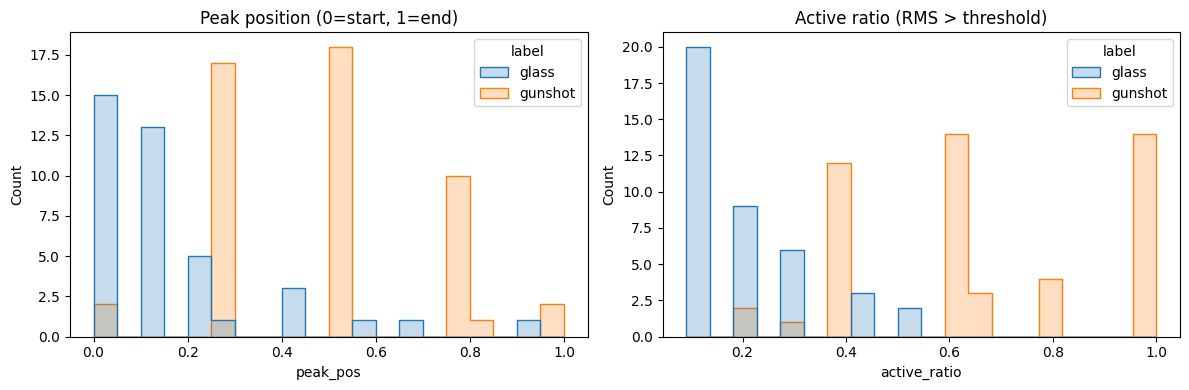

In [9]:
from functools import partial

# Defaults if config cell not run yet
WINDOW_SECONDS = globals().get('WINDOW_SECONDS', 1.0)
WINDOW_HOP = globals().get('WINDOW_HOP', 0.5)
ENERGY_THRESHOLD = globals().get('ENERGY_THRESHOLD', 0.3)
TRIM_SILENCE_BEFORE = globals().get('TRIM_SILENCE_BEFORE', False)
TRIM_TOP_DB = globals().get('TRIM_TOP_DB', 20.0)
TRIM_MIN_KEEP_SECONDS = globals().get('TRIM_MIN_KEEP_SECONDS', 0.0)


def _quantile95(x):
    return x.quantile(0.95)

def compute_energy_detail(sub_df, sample_n=80):
    rows = []
    if len(sub_df) == 0:
        return pd.DataFrame(rows)
    sample = sub_df.sample(n=min(sample_n, len(sub_df)), random_state=SEED)
    for _, r in sample.iterrows():
        y, sr = load_audio(r, sr=TARGET_SR)
        if TRIM_SILENCE_BEFORE:
            y = trim_silence(y, sr, top_db=TRIM_TOP_DB, min_keep_seconds=TRIM_MIN_KEEP_SECONDS)
        frame_length = min(2048, int(WINDOW_SECONDS * sr))
        hop = int(WINDOW_HOP * sr)
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop)[0]
        if rms.size == 0 or rms.max() <= 0:
            continue
        peak_idx = int(np.argmax(rms))
        peak_pos = peak_idx / max(len(rms) - 1, 1)
        active_ratio = float((rms > (rms.max() * ENERGY_THRESHOLD)).sum()) / len(rms)
        rows.append({
            'duration': len(y) / sr,
            'rms_max': float(rms.max()),
            'peak_pos': peak_pos,
            'active_ratio': active_ratio,
        })
    return pd.DataFrame(rows)

energy_detail = []
for lbl in ['glass', 'gunshot']:
    df_lbl = folded_df[folded_df['target_label'] == lbl]
    stats = compute_energy_detail(df_lbl)
    stats['label'] = lbl
    energy_detail.append(stats)
energy_detail = pd.concat(energy_detail, ignore_index=True)
print('Energy detail (mean/median/95%)')
display(energy_detail.groupby('label')[['duration', 'rms_max', 'peak_pos', 'active_ratio']].agg(['mean', 'median', _quantile95]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=energy_detail, x='peak_pos', hue='label', bins=20, ax=axes[0], element='step')
axes[0].set_title('Peak position (0=start, 1=end)')
sns.histplot(data=energy_detail, x='active_ratio', hue='label', bins=20, ax=axes[1], element='step')
axes[1].set_title('Active ratio (RMS > threshold)')
plt.tight_layout(); plt.show()


## Window config / 分窗配置
Override window/threshold parameters for this session. 本次会话窗口/阈值参数。

In [10]:
WINDOW_SECONDS = 1.0
WINDOW_HOP = 0.5
ENERGY_THRESHOLD = 0.3
PEAK_RATIO_THRESHOLD = 0.8
FRONT_PEAK_RATIO = 0.5
EXTRA_SHIFTS = (-0.1, 0.1)
TRIM_SILENCE_BEFORE = True
TRIM_TOP_DB = 20.0
TRIM_MIN_KEEP_SECONDS = 0.2
cfg_rows = [
    ('WINDOW_SECONDS', WINDOW_SECONDS, 'window length (s): longer=more context, shorter=less latency but may miss long events'),
    ('WINDOW_HOP', WINDOW_HOP, 'hop (s): smaller=denser windows, larger=fewer windows/less overlap'),
    ('ENERGY_THRESHOLD', ENERGY_THRESHOLD, 'energy mask threshold (relative): higher=drop quiet windows, lower=keep more'),
    ('PEAK_RATIO_THRESHOLD', PEAK_RATIO_THRESHOLD, 'peak energy ratio (relative to clip): higher=only strong peaks kept'),
    ('FRONT_PEAK_RATIO', FRONT_PEAK_RATIO, 'peak position limit (0-1): lower=peaks must be earlier'),
    ('EXTRA_SHIFTS', EXTRA_SHIFTS, 'fallback shifts (s) when no peak windows kept'),
    ('TRIM_SILENCE_BEFORE', TRIM_SILENCE_BEFORE, 'apply silence trim before windowing'),
    ('TRIM_TOP_DB', TRIM_TOP_DB, 'trim threshold dB: higher=more aggressive trimming'),
    ('TRIM_MIN_KEEP_SECONDS', TRIM_MIN_KEEP_SECONDS, 'min segment kept after trim (s)')
]
print('Windowing / energy config:')
for k,v,desc in cfg_rows:
    print(f'- {k}: {v} -> {desc}')


Windowing / energy config:
- WINDOW_SECONDS: 1.0 -> window length (s): longer=more context, shorter=less latency but may miss long events
- WINDOW_HOP: 0.5 -> hop (s): smaller=denser windows, larger=fewer windows/less overlap
- ENERGY_THRESHOLD: 0.3 -> energy mask threshold (relative): higher=drop quiet windows, lower=keep more
- PEAK_RATIO_THRESHOLD: 0.8 -> peak energy ratio (relative to clip): higher=only strong peaks kept
- FRONT_PEAK_RATIO: 0.5 -> peak position limit (0-1): lower=peaks must be earlier
- EXTRA_SHIFTS: (-0.1, 0.1) -> fallback shifts (s) when no peak windows kept
- TRIM_SILENCE_BEFORE: True -> apply silence trim before windowing
- TRIM_TOP_DB: 20.0 -> trim threshold dB: higher=more aggressive trimming
- TRIM_MIN_KEEP_SECONDS: 0.2 -> min segment kept after trim (s)


## Base window summary / 基础分窗统计
Generate aligned windows for glass & gunshot, count per clip. 对玻璃/枪声分窗，统计每clip窗口数。

In [11]:

# all_labels = labels_for_align + [BACKGROUND_LABEL]
# print(all_labels)
# display(folded_df[folded_df['target_label'].isin(all_labels)])

In [25]:
records = []
labels_for_align = ['glass', 'gunshot']
all_labels = sorted(folded_df['target_label'].unique().tolist())
subset = folded_df[folded_df['target_label'].isin(all_labels)]
for _, row in subset.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=labels_for_align,
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    records.append({
        'label': row['target_label'],
        'fold': row.get('fold_id', -1),
        'clip': Path(row['filepath']).stem,
        'n_windows': len(wins),
    })
base_df = pd.DataFrame(records)

# 简单键值统计：每类多少个窗口
if base_df.empty:
    print('No windows found')
else:
    total_windows = int(base_df['n_windows'].sum())
    print(f"Total clips: {len(base_df)}, total windows: {total_windows}")
    label_windows = base_df.groupby('label')['n_windows'].sum().reindex(all_labels, fill_value=0)
    print("\nWindows per label:")
    for lbl, cnt in label_windows.to_dict().items():
        print(f"  {lbl}: {int(cnt)}")

    if 'fold' in base_df.columns:
        fold_totals = base_df.pivot_table(index='fold', columns='label', values='n_windows', aggfunc='sum').fillna(0)
        print("\nWindows per fold x label (total windows):")
        display(fold_totals)


Total clips: 2050, total windows: 9706

Windows per label:
  airplane: 310
  breathing: 135
  brushing_teeth: 263
  can_opening: 50
  car_horn: 177
  cat: 109
  chainsaw: 256
  chirping_birds: 225
  church_bells: 299
  clapping: 258
  clock_alarm: 254
  clock_tick: 159
  coughing: 65
  cow: 154
  crackling_fire: 253
  crickets: 314
  crow: 218
  crying_baby: 133
  dog: 83
  door_wood_creaks: 156
  door_wood_knock: 75
  drinking_sipping: 84
  engine: 320
  fireworks: 94
  footsteps: 161
  frog: 196
  glass: 57
  gunshot: 72
  hand_saw: 215
  helicopter: 327
  hen: 134
  insects: 222
  keyboard_typing: 174
  laughing: 135
  mouse_click: 131
  pig: 153
  pouring_water: 154
  rain: 345
  rooster: 69
  sea_waves: 285
  sheep: 203
  siren: 295
  sneezing: 41
  snoring: 109
  thunderstorm: 164
  toilet_flush: 211
  train: 320
  vacuum_cleaner: 332
  washing_machine: 339
  water_drops: 90
  wind: 328

Windows per fold x label (total windows):


label  airplane  breathing  brushing_teeth  can_opening  car_horn  cat  \
fold                                                                     
1            60         26              64           10        23   29   
2            69         29              48           12        36   21   
3            61         24              46            8        39   13   
4            61         30              51            9        32   23   
5            59         26              54           11        47   23   

label  chainsaw  chirping_birds  church_bells  clapping  ...  siren  sneezing  \
fold                                                     ...                    
1            60              44            58        61  ...     66         8   
2            50              42            63        43  ...     62         9   
3            38              56            53        64  ...     51         8   
4            57              43            65        36  ...     58         8   
5            51              40            60        54  ...     58         8   

label  snoring  thunderstorm  toilet_flush  train  vacuum_cleaner  \
fold                                                                
1           19            27            36     57              72   
2           23            32            44     69              72   
3           22            23            49     63              63   
4           20            38            40     61              60   
5           25            44            42     70              65   

label  washing_machine  water_drops  wind  
fold                                       
1                   70           19    66  
2                   65           16    63  
3                   68           14    64  
4                   64           20    70  
5                   72           21    65  

[5 rows x 51 columns]

## Window QA visualization / 分窗可视化QA
Plot waveform+RMS with kept window boundaries for one glass and one gunshot sample. 对玻璃/枪声各选一条，画波形+RMS并标出保留的窗口边界。



=== Sample 1: glass | esc50 | cache/data_resampled/data/esc50/audio/5-260433-A-39.wav
Full clip (5.00s)


start_sec  end_sec  peak_ratio  peak_position  status  \
0        NaN      NaN         NaN            NaN    info   
1   0.278639      5.0         NaN            NaN  remove   
2   0.000000      1.0         1.0       0.001678    keep   

                                              reason  
0  len_raw=5.000s len_trim=0.279s lead_trim=0.000...  
1                                   silent_trim_tail  
2                                               pass

Length raw=5.00s after_trim=0.28s


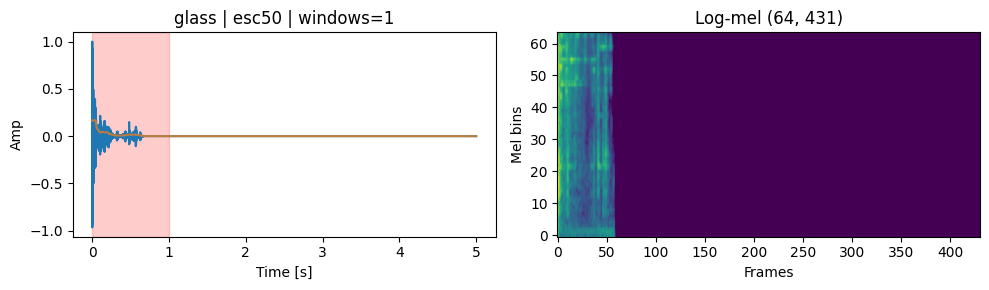

Play window 0: 0.00s - 1.00s



=== Sample 2: gunshot | gunshot_kaggle | cache/data_resampled/data/gunshot_kaggle/M249/6 (46).wav
Full clip (2.00s)


start_sec  end_sec  peak_ratio  peak_position  status  \
0        NaN      NaN         NaN            NaN    info   
1     0.0000   0.2322         NaN            NaN  remove   
2     0.2322   1.2322         1.0       0.035147    keep   
3     0.7322   1.7322         1.0       0.454195    keep   

                                              reason  
0  len_raw=2.000s len_trim=1.768s lead_trim=0.232...  
1                                   silent_trim_head  
2                                               pass  
3                                               pass

Length raw=2.00s after_trim=1.77s


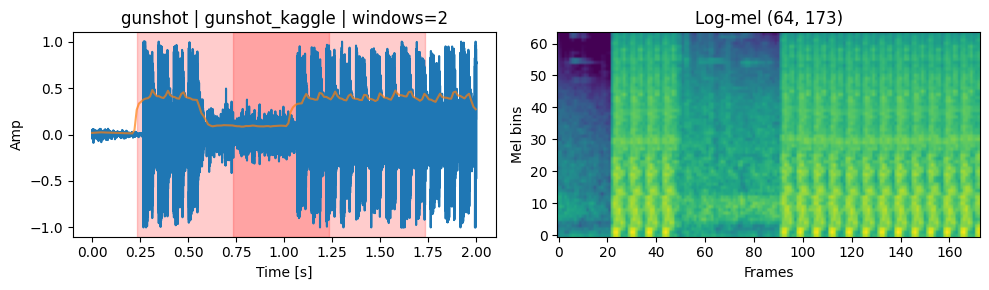

Play window 0: 0.23s - 1.23s


Play window 1: 0.73s - 1.73s



=== Sample 3: siren | esc50 | cache/data_resampled/data/esc50/audio/1-31482-B-42.wav
Full clip (5.00s)


start_sec  end_sec peak_ratio peak_position status  \
0        NaN      NaN       None          None   info   
1        0.0      1.0       None          None   keep   
2        0.5      1.5       None          None   keep   
3        1.0      2.0       None          None   keep   
4        1.5      2.5       None          None   keep   
5        2.0      3.0       None          None   keep   
6        2.5      3.5       None          None   keep   
7        3.0      4.0       None          None   keep   
8        3.5      4.5       None          None   keep   
9        4.0      5.0       None          None   keep   

                                              reason  
0  len_raw=5.000s len_trim=5.000s lead_trim=0.000...  
1                                               pass  
2                                               pass  
3                                               pass  
4                                               pass  
5                                               pass  
6                                               pass  
7                                               pass  
8                                               pass  
9                                               pass

Length raw=5.00s after_trim=5.00s


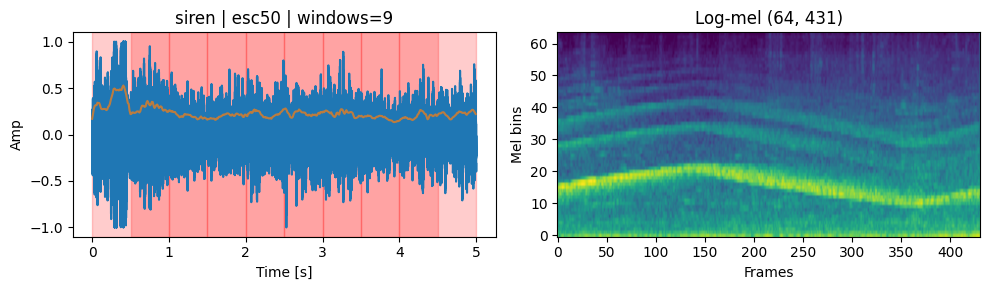

Play window 0: 0.00s - 1.00s


Play window 1: 0.50s - 1.50s


Play window 2: 1.00s - 2.00s


Play window 3: 1.50s - 2.50s


Play window 4: 2.00s - 3.00s


Play window 5: 2.50s - 3.50s


Play window 6: 3.00s - 4.00s


Play window 7: 3.50s - 4.50s


Play window 8: 4.00s - 5.00s


In [30]:
SEED = 5


## Window QA (combined viz + listening) / 分窗 QA（可视化+试听）
# Sample one glass, one gunshot, one background (if available); visualize windows and listen to kept windows.
samples_cfg = ['glass','gunshot', BACKGROUND_LABEL]
samples = []
for lbl in samples_cfg:
    subset = folded_df[folded_df['target_label']==lbl]
    if len(subset) == 0:
        continue
    samples.append(subset.sample(random_state=SEED).iloc[0])
if not any(s.get('target_label') == BACKGROUND_LABEL for s in samples):
    bg_pool = folded_df[~folded_df['target_label'].isin(['glass','gunshot'])]
    if len(bg_pool) > 0:
        samples.append(bg_pool.sample(random_state=SEED).iloc[0])
if len(samples) == 0:
    print('No samples available for QA')
else:
    for idx, row in enumerate(samples):
        print(f"\n=== Sample {idx+1}: {row.get('target_label','')} | {row.get('source','')} | {row.get('filepath','')}")
        y, sr = load_audio(row, sr=TARGET_SR)
        print(f"Full clip ({len(y)/sr:.2f}s)")
        display(Audio(y, rate=sr))
        # 记录窗口决策日志
        logs = []
        wins = generate_aligned_windows(
            row,
            align_labels=['glass','gunshot'],
            extra_shifts=EXTRA_SHIFTS,
            energy_threshold=ENERGY_THRESHOLD,
            peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
            front_peak_ratio=FRONT_PEAK_RATIO,
            trim_silence_before=TRIM_SILENCE_BEFORE,
            trim_top_db=TRIM_TOP_DB,
            trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
            label_params=WINDOW_PARAMS,
            debug=True,
            debug_sink=logs,
        )
        # 打印日志表，便于查看被丢弃原因
        if logs:
            import pandas as pd
            display(pd.DataFrame(logs))
        # 记录修剪前后长度
        if TRIM_SILENCE_BEFORE:
            y_trim = trim_silence(y, sr, top_db=TRIM_TOP_DB, min_keep_seconds=TRIM_MIN_KEEP_SECONDS)
            print(f"Length raw={len(y)/sr:.2f}s after_trim={len(y_trim)/sr:.2f}s")
        hop_len = int(WINDOW_HOP * sr)
        win_len = int(WINDOW_SECONDS * sr)
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        times = np.arange(len(y)) / sr
        axes[0].plot(times, y)
        axes[0].set_title(f"{row['target_label']} | {row['source']} | windows={len(wins)}")
        axes[0].set_xlabel('Time [s]')
        axes[0].set_ylabel('Amp')
        rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=256)[0]
        rms_times = (np.arange(len(rms)) * 256) / sr
        axes[0].plot(rms_times, rms, alpha=0.7)
        # 使用日志中的 start_sec 标记被保留的窗口
        kept_starts = [l['start_sec'] for l in logs if l.get('status') == 'keep' and l.get('start_sec') is not None]
        for start_sec in kept_starts:
            axes[0].axvspan(start_sec, start_sec + WINDOW_SECONDS, color='red', alpha=0.2)
        mel = log_mel_spectrogram(y, sr, n_fft=HOP_LENGTH*4, hop_length=HOP_LENGTH, n_mels=N_MELS)
        axes[1].imshow(mel, aspect='auto', origin='lower')
        axes[1].set_title(f'Log-mel {mel.shape}')
        axes[1].set_xlabel('Frames')
        axes[1].set_ylabel('Mel bins')
        plt.tight_layout(); plt.show()
        for w_idx, w in enumerate(wins):
            start = kept_starts[w_idx] if w_idx < len(kept_starts) else w_idx * hop_len / sr
            end = start + WINDOW_SECONDS
            print(f"Play window {w_idx}: {start:.2f}s - {end:.2f}s")
            display(Audio(w, rate=sr))


## Play 10 event windows / 播放10个事件窗口
Play up to 10 kept windows (glass/gunshot) for quick QA. 播放最多10个保留窗口，便于快速听检。


In [31]:
clips = folded_df[folded_df['target_label'].isin(['glass','gunshot'])].sample(frac=1.0, random_state=SEED)
played = 0
for _, row in clips.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    for w_idx, w in enumerate(wins):
        print('{} | {} | window {}'.format(row['target_label'], Path(row['filepath']).stem, w_idx))
        display(Audio(w, rate=TARGET_SR))
        played += 1
        if played >= 10:
            break
    if played >= 10:
        break
if played == 0:
    print('No windows to play')

if not wins:
    print('No windows to inspect for shape')
else:
    mel = log_mel_spectrogram(wins[0], sr=TARGET_SR)
    print(f'log-mel shape: {mel.shape}; model input: (batch, 1, {mel.shape[0]}, {mel.shape[1]})')

gunshot | 1 (23) | window 0


gunshot | 1 (23) | window 1


gunshot | 1 (23) | window 2


glass | 4-204123-A-39 | window 0


gunshot | 5 (57) | window 0


gunshot | 3 (73) | window 0


gunshot | 2 (5) | window 0


glass | 5-260433-A-39 | window 0


glass | 4-204119-A-39 | window 0


gunshot | 3 (45) | window 0


log-mel shape: (64, 87); model input: (batch, 1, 64, 87)


## Cache prep / 缓存准备
- 规范 target_label 为 glass/gunshot/background，补齐 filename 字段。
- 打印标签/折分布，作为缓存输入。


In [40]:
# Build window-level dataframe (one row per window)
window_records = []
labels_for_align = TARGET_LABELS  # 正类对齐峰值，其余走背景逻辑
for _, row in folded_df.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=labels_for_align,
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    base_label = row.get('canonical_label', row.get('target_label', 'unknown'))
    mapped_label = base_label if base_label in TARGET_LABELS else BACKGROUND_LABEL
    clip_id = Path(row['filepath']).stem
    for w_idx, w in enumerate(wins):
        start_sec = w_idx * WINDOW_HOP
        end_sec = start_sec + WINDOW_SECONDS
        window_records.append({
            'clip_id': clip_id,
            'window_id': f"w{w_idx}",
            'fold_id': row.get('fold_id', -1),
            'source': row.get('source', ''),
            'orig_label': base_label,
            'target_label': mapped_label,
            'start_sec': start_sec,
            'end_sec': end_sec,
            'length_sec': WINDOW_SECONDS,
        })

window_df = pd.DataFrame(window_records)
print(f"Total windows: {len(window_df)}")
label_totals = window_df['target_label'].value_counts().to_dict()
print("Windows per label (total):")
for k, v in label_totals.items():
    print(f"  {k}: {v}")

if 'fold_id' in window_df.columns:
    print("\nFold x label (total windows):")
    pivot = window_df.pivot_table(index='fold_id', columns='target_label', values='window_id', aggfunc='count').fillna(0)
    print(pivot.to_string())


display(window_df[:5])

Total windows: 9706
Windows per label (total):
  background: 9577
  gunshot: 72
  glass: 57

Fold x label (total windows):
target_label  background  glass  gunshot
fold_id                                 
1                   1906      8       13
2                   1914     12       15
3                   1859      9       13
4                   1911      8       16
5                   1987     20       15


clip_id window_id  fold_id source orig_label target_label  start_sec  \
0  5-215445-A-47        w0        1  esc50   airplane   background        0.0   
1  5-215445-A-47        w1        1  esc50   airplane   background        0.5   
2  5-215445-A-47        w2        1  esc50   airplane   background        1.0   
3  5-215445-A-47        w3        1  esc50   airplane   background        1.5   
4  5-215445-A-47        w4        1  esc50   airplane   background        2.0   

   end_sec  length_sec  
0      1.0         1.0  
1      1.5         1.0  
2      2.0         1.0  
3      2.5         1.0  
4      3.0         1.0

## Augment plan & cache dirs / 增强计划与缓存目录
设定 pipeline、对齐标签、Smoke/Full 输出目录。

In [42]:
PIPELINE_PLAN = GLASS_PIPELINE_PLAN
ALIGN_LABELS = CACHE_ALIGN_LABELS
SMOKE_CACHE_DIR = CACHE_MEL64 / 'mel64_smoke_multi'
FULL_CACHE_DIR = CACHE_MEL64 / 'mel64_multi'
SMOKE_COUNTS = {'glass': 10, 'gunshot': 10, 'background': 20}
print('Pipeline:', PIPELINE_PLAN)
print('Smoke dir:', SMOKE_CACHE_DIR)
print('Full dir:', FULL_CACHE_DIR)


Pipeline: {'shift_gain': {'copies': 2}, 'stretch_reverb': {'copies': 2}, 'shift_mix': {'copies': 2}, 'filter_gain': {'copies': 2}, 'gain_mix': {'copies': 1}, 'stretch_filter': {'copies': 1}}
Smoke dir: /workspace/cache/mel64/mel64_smoke_multi
Full dir: /workspace/cache/mel64/mel64_multi


## Smoke cache build / Smoke 缓存
少量抽样快速验证切窗+增强，生成索引。

In [18]:
# smoke_parts = []
# for lbl, n in SMOKE_COUNTS.items():
#     sub = cache_df[cache_df['target_label'] == lbl]
#     if len(sub) == 0:
#         continue
#     take = min(n, len(sub))
#     smoke_parts.append(sub.sample(n=take, random_state=SEED))
# smoke_df = pd.concat(smoke_parts, ignore_index=True) if smoke_parts else pd.DataFrame()
# print('Smoke clips per label:', smoke_df['target_label'].value_counts().to_dict())
# SMOKE_CACHE_DIR.mkdir(parents=True, exist_ok=True)
# cache_index_smoke = build_cache_index(
#     smoke_df,
#     pipeline_plan=PIPELINE_PLAN,
#     cache_dir=SMOKE_CACHE_DIR,
#     align_labels=ALIGN_LABELS,
#     extra_shifts=EXTRA_SHIFTS,
#     energy_threshold=ENERGY_THRESHOLD,
#     peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
#     front_peak_ratio=FRONT_PEAK_RATIO,
#     seed=SEED,
# )
# print('Smoke cache size:', len(cache_index_smoke))
# display(cache_index_smoke['label'].value_counts())


## Listen: base vs aug (smoke) / 试听增强样本
抽样 glass/gunshot 各 1 条，播放 base 和各 pipeline 增强（mix 会抽背景）。


In [43]:
rng = np.random.default_rng(SEED)
bg_pool = cache_df[cache_df['target_label'] == BACKGROUND_LABEL]

def sample_bg_chunk(length):
    if bg_pool.empty:
        return None
    row = bg_pool.sample(random_state=SEED).iloc[0]
    y_bg, _ = load_audio(row, sr=TARGET_SR)
    if len(y_bg) < length:
        y_bg = np.pad(y_bg, (0, length - len(y_bg)))
    start = rng.integers(0, max(1, len(y_bg) - length + 1))
    return y_bg[start:start+length]

for lbl in ['glass','gunshot']:
    sub = cache_df[cache_df['target_label'] == lbl]
    if sub.empty:
        continue
    row = sub.sample(random_state=SEED).iloc[0]
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    if not wins:
        continue
    base = wins[0]
    print(f"Label={lbl} | clip={Path(row['filepath']).stem} | base")
    display(Audio(base, rate=TARGET_SR))
    for name, cfg in PIPELINE_PLAN.items():
        bg = None
        if 'mix' in PIPELINE_REGISTRY[name]:
            bg = sample_bg_chunk(len(base))
        aug = run_pipeline(base, name, background=bg)
        print(f" -> {name}")
        display(Audio(aug.audio, rate=TARGET_SR))
    print('-'*40)


Label=glass | clip=5-260433-A-39 | base


 -> shift_gain


 -> stretch_reverb


 -> shift_mix


 -> filter_gain


 -> gain_mix


 -> stretch_filter


----------------------------------------
Label=gunshot | clip=6 (46) | base


 -> shift_gain


 -> stretch_reverb


 -> shift_mix


 -> filter_gain


 -> gain_mix


 -> stretch_filter


----------------------------------------


In [72]:
TARGET_PER_FOLD = {'glass': 250, 'gunshot': 250}
plan_names = list(PIPELINE_REGISTRY.keys())  # 或限定为你的 plan key
rng = np.random.default_rng(SEED)
aug_records = []

for lab, target in TARGET_PER_FOLD.items():
    for fold, group in folded_df[folded_df['canonical_label'] == lab].groupby('fold_id'):
        # 切窗汇总
        win_pool = []
        for _, row in group.iterrows():
            wins = generate_aligned_windows(
                row,
                align_labels=TARGET_LABELS,
                extra_shifts=EXTRA_SHIFTS,
                energy_threshold=ENERGY_THRESHOLD,
                peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
                front_peak_ratio=FRONT_PEAK_RATIO,
                trim_silence_before=TRIM_SILENCE_BEFORE,
                trim_top_db=TRIM_TOP_DB,
                trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
                label_params=WINDOW_PARAMS,
            )
            clip_id = Path(row['filepath']).stem
            for w_idx, w in enumerate(wins):
                win_pool.append((clip_id, w_idx, w, row))
        if not win_pool:
            continue

        count = 0
        # 覆盖阶段：每个窗口×每种 pipeline 各至少一次，直到达标
        for clip_id, w_idx, w, row in win_pool:
            for name in plan_names:
                if count >= target:
                    break
                bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
                aug = run_pipeline(w, name, background=bg)
                aug_records.append({
                    'clip_id': clip_id,
                    'window_id': f"{clip_id}_w{w_idx}",
                    'fold_id': fold,
                    'source': row.get('source',''),
                    'original_label': lab,
                    'target_label': lab,
                    'pipeline': name,
                    'copy': 0,
                    'length_sec': len(aug.audio) / TARGET_SR,
                    'audio': aug.audio,
                })
                count += 1
            if count >= target:
                break

        # 填补缺口：随机窗口+随机 pipeline
        while count < target:
            idx = rng.integers(0, len(win_pool))
            clip_id, w_idx, w, row = win_pool[idx]
            name = rng.choice(plan_names)
            bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
            aug = run_pipeline(w, name, background=bg)
            aug_records.append({
                'clip_id': clip_id,
                'window_id': f"{clip_id}_w{w_idx}",
                'fold_id': fold,
                'source': row.get('source',''),
                'original_label': lab,
                'target_label': lab,
                'pipeline': name,
                'copy': 0,
                'length_sec': len(aug.audio) / TARGET_SR,
                'audio': aug.audio,
            })
            count += 1

aug_df = pd.DataFrame(aug_records)
display(aug_df[:5])

print("\nWindows per fold x target_label x pipeline (with totals):")
pivot = aug_df.pivot_table(
    index='fold_id',
    columns=['target_label', 'pipeline'],
    values='window_id',
    aggfunc='count'
).fillna(0).astype(int)

# 列总计
pivot['total'] = pivot.sum(axis=1)
# 行总计
total_row = pivot.sum(axis=0).to_frame().T
total_row.index = ['total']

pivot_with_totals = pd.concat([pivot, total_row])
print(pivot_with_totals.to_string())


clip_id         window_id  fold_id source original_label  \
0  4-204121-A-39  4-204121-A-39_w0        1  esc50          glass   
1  4-204121-A-39  4-204121-A-39_w0        1  esc50          glass   
2  4-204121-A-39  4-204121-A-39_w0        1  esc50          glass   
3  4-204121-A-39  4-204121-A-39_w0        1  esc50          glass   
4  4-204121-A-39  4-204121-A-39_w0        1  esc50          glass   

  target_label        pipeline  copy  length_sec  \
0        glass      shift_gain     0         1.0   
1        glass  stretch_reverb     0         1.0   
2        glass       shift_mix     0         1.0   
3        glass     filter_gain     0         1.0   
4        glass        gain_mix     0         1.0   

                                               audio  
0  [-0.0008189142, -0.0008014905, -0.0007666431, ...  
1  [0.001130190634129302, 0.0017979254088712187, ...  
2  [-0.0021822993, -0.0039678165, -0.0007439656, ...  
3  [3.963616475054906e-05, 0.00026432654339950823...  
4  [0.0048735877, 0.005513261, 0.0047233906, 0.00...


Windows per fold x target_label x pipeline (with totals):
                               1    2    3    4    5  total
target_label pipeline                                      
glass        filter_gain      32   47   38   34   36    187
             gain_mix         45   42   43   40   43    213
             shift_gain       41   45   49   40   49    224
             shift_mix        46   41   42   41   33    203
             stretch_filter   43   32   42   52   47    216
             stretch_reverb   43   43   36   43   42    207
gunshot      filter_gain      46   42   52   44   43    227
             gain_mix         34   42   34   39   46    195
             shift_gain       43   40   47   43   45    218
             shift_mix        49   48   35   43   35    210
             stretch_filter   42   40   44   40   35    201
             stretch_reverb   36   38   38   41   46    199
total                        500  500  500  500  500   2500


In [87]:
TARGET_BG_PER_FOLD = 400
plan_names = list(PIPELINE_REGISTRY.keys())  # 如需限定可自定义
rng = np.random.default_rng(SEED)
bg_aug_records = []


# bg_aug_records = []
# TARGET_BG_PER_FOLD = 400
# plan_names = list(PIPELINE_REGISTRY.keys())
# rng = np.random.default_rng(SEED)

for fold, group in folded_df[~folded_df['canonical_label'].isin(TARGET_LABELS)].groupby('fold_id'):
    win_pool = []
    for _, row in group.iterrows():
        wins = generate_aligned_windows(
            row,
            align_labels=TARGET_LABELS,  # 非正类走背景逻辑
            extra_shifts=EXTRA_SHIFTS,
            energy_threshold=ENERGY_THRESHOLD,
            peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
            front_peak_ratio=FRONT_PEAK_RATIO,
            trim_silence_before=TRIM_SILENCE_BEFORE,
            trim_top_db=TRIM_TOP_DB,
            trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
            label_params=WINDOW_PARAMS,
        )
        clip_id = Path(row['filepath']).stem
        orig_label = row.get('canonical_label', row.get('target_label', 'unknown'))
        for w_idx, w in enumerate(wins):
            win_pool.append((clip_id, w_idx, w, row, orig_label))
    if not win_pool:
        continue

    # 按原始类分桶并打乱
    win_by_label = {}
    for item in win_pool:
        win_by_label.setdefault(item[4], []).append(item)
    for lab in win_by_label:
        rng.shuffle(win_by_label[lab])

    labels = sorted(win_by_label.keys())
    n_labels = len(labels)
    base_quota = TARGET_BG_PER_FOLD // n_labels
    remainder = TARGET_BG_PER_FOLD % n_labels
    count = 0

    def add_item(item, pipeline_name, suffix=""):
        nonlocal count
        clip_id, w_idx, w, row, orig_label = item
        bg_aug_records.append({
            'clip_id': clip_id,
            'window_id': f"{clip_id}_w{w_idx}{suffix}",
            'fold_id': fold,
            'source': row.get('source',''),
            'original_label': orig_label,
            'target_label': BACKGROUND_LABEL,
            'pipeline': pipeline_name,
            'copy': 0,
            'length_sec': len(w)/TARGET_SR,
            'audio': w,
        })
        count += 1

    # 基准分配
    for lab in labels:
        pool = win_by_label[lab]
        take_n = min(base_quota, len(pool))
        for i in range(take_n):
            add_item(pool[i], 'base')
        win_by_label[lab] = pool[take_n:]

    # 分配余数
    rem = remainder
    while rem > 0:
        for lab in labels:
            if rem <= 0:
                break
            pool = win_by_label[lab]
            if pool:
                add_item(pool[0], 'base')
                win_by_label[lab] = pool[1:]
                rem -= 1

    # 补缺到 400：随机标签/窗口 + 随机 pipeline
    while count < TARGET_BG_PER_FOLD:
        lab = rng.choice(labels)
        pool = win_by_label.get(lab, [])
        if not pool:
            # 若该类没有剩余原始窗，用已加入的该类窗口再增广
            existing = [r for r in bg_aug_records if r['fold_id']==fold and r['original_label']==lab]
            if not existing:
                continue
            base_row = rng.choice(existing)
            w = base_row['audio']
            clip_id = base_row['clip_id']
            orig_label = lab
        else:
            clip_id, w_idx, w, row, orig_label = pool[0]
            win_by_label[lab] = pool[1:]
        name = rng.choice(plan_names)
        bg_audio = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
        aug = run_pipeline(w, name, background=bg_audio)
        bg_aug_records.append({
            'clip_id': clip_id,
            'window_id': f"{clip_id}_bg_{name}_{count}",
            'fold_id': fold,
            'source': row.get('source','') if 'row' in locals() else '',
            'original_label': orig_label,
            'target_label': BACKGROUND_LABEL,
            'pipeline': name,
            'copy': 0,
            'length_sec': len(aug.audio)/TARGET_SR,
            'audio': aug.audio,
        })
        count += 1









# for fold, group in folded_df[~folded_df['canonical_label'].isin(TARGET_LABELS)].groupby('fold_id'):
#     win_pool = []
#     for _, row in group.iterrows():
#         wins = generate_aligned_windows(
#             row,
#             align_labels=TARGET_LABELS,  # 非正类走背景逻辑
#             extra_shifts=EXTRA_SHIFTS,
#             energy_threshold=ENERGY_THRESHOLD,
#             peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
#             front_peak_ratio=FRONT_PEAK_RATIO,
#             trim_silence_before=TRIM_SILENCE_BEFORE,
#             trim_top_db=TRIM_TOP_DB,
#             trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
#             label_params=WINDOW_PARAMS,
#         )
#         clip_id = Path(row['filepath']).stem
#         orig_label = row.get('canonical_label', row.get('target_label', 'unknown'))
#         for w_idx, w in enumerate(wins):
#             win_pool.append((clip_id, w_idx, w, row, orig_label))
#     if not win_pool:
#         continue

#     # win_pool 按原始类分桶，先打乱
#     win_by_label = {}
#     for item in win_pool:
#         clip_id, w_idx, w, row, orig_label = item
#         win_by_label.setdefault(orig_label, []).append(item)
#     for lab in win_by_label:
#         rng.shuffle(win_by_label[lab])

#     labels = sorted(win_by_label.keys())
#     n_labels = len(labels)
#     target = TARGET_BG_PER_FOLD
#     base_quota = target // n_labels
#     remainder = target % n_labels

#     def take_one(item, pipeline_name, extra_suffix=""):
#         clip_id, w_idx, w, row, orig_label = item
#         bg_aug_records.append({
#             'clip_id': clip_id,
#             'window_id': f"{clip_id}_w{w_idx}{extra_suffix}",
#             'fold_id': fold,
#             'source': row.get('source',''),
#             'original_label': orig_label,
#             'target_label': BACKGROUND_LABEL,
#             'pipeline': pipeline_name,
#             'copy': 0,
#             'length_sec': len(w) / TARGET_SR,
#             'audio': w,
#         })

#     # 第一轮：每类先拿 base_quota 个（或该类全部）
#     for lab in labels:
#         quota = base_quota
#         pool = win_by_label.get(lab, [])
#         take_n = min(quota, len(pool))
#         for i in range(take_n):
#             take_one(pool[i], 'base')
#         win_by_label[lab] = pool[take_n:]

#     # 分配 remainder：按标签轮询，能取就取
#     rem = remainder
#     while rem > 0:
#         for lab in labels:
#             if rem <= 0:
#                 break
#             pool = win_by_label.get(lab, [])
#             if pool:
#                 take_one(pool[0], 'base')
#                 win_by_label[lab] = pool[1:]
#                 rem -= 1

#     # 统计当前数量
#     current = sum(1 for r in bg_aug_records if r['fold_id'] == fold)
#     # 补缺到 target：随机标签、随机 pipeline，对该标签已有或剩余窗口增广
#     while current < target:
#         # 选择标签（存在原始或已用过的标签集合）
#         lab = rng.choice(labels)
#         pool = win_by_label.get(lab, [])
#         if not pool:
#             # 没剩余原始窗了，回头用该标签已经取过的窗口做增广
#             pool = [r for r in bg_aug_records if r['fold_id']==fold and r['original_label']==lab]
#             if not pool:
#                 # 若仍无，则跳过该标签
#                 continue
#             # 取已有窗口的 audio
#             clip_id = pool[rng.integers(0, len(pool))]['clip_id']
#             # 找到对应 audio（从 bg_aug_records 中取）
#             base_row = rng.choice(pool)
#             w = base_row['audio']
#             orig_label = base_row['original_label']
#         else:
#             clip_id, w_idx, w, row, orig_label = pool[0]
#             win_by_label[lab] = pool[1:]
#         name = rng.choice(plan_names)
#         bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
#         aug = run_pipeline(w, name, background=bg)
#         bg_aug_records.append({
#             'clip_id': clip_id,
#             'window_id': f"{clip_id}_bg_{name}_{current}",
#             'fold_id': fold,
#             'source': row.get('source','') if isinstance(row, dict) else (row.get('source','') if hasattr(row, 'get') else ''),
#             'original_label': orig_label,
#             'target_label': BACKGROUND_LABEL,
#             'pipeline': name,
#             'copy': 0,
#             'length_sec': len(aug.audio)/TARGET_SR,
#             'audio': aug.audio,
#         })
#         current += 1
    
#     count = 0
#     target = TARGET_BG_PER_FOLD
#     for clip_id, w_idx, w, row, orig_label in win_pool:
#         if count >= target:
#             break
#         bg_aug_records.append({
#             'clip_id': clip_id,
#             'window_id': f"{clip_id}_w{w_idx}",
#             'fold_id': fold,
#             'source': row.get('source',''),
#             'original_label': orig_label,
#             'target_label': BACKGROUND_LABEL,
#             'pipeline': 'base',
#             'copy': 0,
#             'length_sec': len(w)/TARGET_SR,
#             'audio': w,
#         })
#         count += 1

#     while count < target:
#         idx = rng.integers(0, len(win_pool))
#         clip_id, w_idx, w, row, orig_label = win_pool[idx]
#         name = rng.choice(plan_names)
#         bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
#         aug = run_pipeline(w, name, background=bg)
#         bg_aug_records.append({
#             'clip_id': clip_id,
#             'window_id': f"{clip_id}_w{w_idx}_bg_{name}",
#             'fold_id': fold,
#             'source': row.get('source',''),
#             'original_label': orig_label,
#             'target_label': BACKGROUND_LABEL,
#             'pipeline': name,
#             'copy': 0,
#             'length_sec': len(aug.audio)/TARGET_SR,
#             'audio': aug.audio,
#         })
#         count += 1









bg_df = pd.DataFrame(bg_aug_records)
print(f"Background labels: {len(bg_labels)}, sampled windows: {len(bg_df)}")

pivot_bg = bg_df.pivot_table(
    index='fold_id',
    columns=['pipeline', 'original_label'],
    values='window_id',
    aggfunc='count'
).fillna(0).astype(int)

pivot_bg['total'] = pivot_bg.sum(axis=1)
total_row = pivot_bg.sum(axis=0).to_frame().T
total_row.index = ['total']

pivot_bg_tot = pd.concat([pivot_bg, total_row])
print("\nBackground windows per fold x pipeline x original_label (with totals):")
print(pivot_bg_tot.T.to_string())





SyntaxError: no binding for nonlocal 'count' found (2169243533.py, line 48)

In [45]:
# Sample background windows: each non-target label 40 windows from distinct clips
rng = np.random.default_rng(SEED)
bg_labels = sorted([lab for lab in folded_df['canonical_label'].unique() if lab not in TARGET_LABELS])
bg_records = []

for lab in bg_labels:
    lab_df = folded_df[folded_df['canonical_label'] == lab]
    if lab_df.empty:
        continue
    # 先按 clip 打乱，确保尽量不同 clip
    lab_df = lab_df.sample(frac=1.0, random_state=SEED)
    picked = 0
    for _, row in lab_df.iterrows():
        wins = generate_aligned_windows(
            row,
            align_labels=TARGET_LABELS,  # 正类才对齐峰值，背景走能量掩码
            extra_shifts=EXTRA_SHIFTS,
            energy_threshold=ENERGY_THRESHOLD,
            peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
            front_peak_ratio=FRONT_PEAK_RATIO,
            trim_silence_before=TRIM_SILENCE_BEFORE,
            trim_top_db=TRIM_TOP_DB,
            trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
            label_params=WINDOW_PARAMS,
        )
        if not wins:
            continue
        clip_id = Path(row['filepath']).stem
        for w_idx, w in enumerate(wins):
            start_sec = w_idx * WINDOW_HOP
            end_sec = start_sec + WINDOW_SECONDS
            bg_records.append({
                'clip_id': clip_id,
                'window_id': f"{clip_id}_w{w_idx}",
                'fold_id': row.get('fold_id', -1),
                'source': row.get('source', ''),
                'orig_label': lab,
                'target_label': BACKGROUND_LABEL,
                'start_sec': start_sec,
                'end_sec': end_sec,
                'length_sec': WINDOW_SECONDS,
            })
            picked += 1
            if picked >= 40:
                break
        if picked >= 40:
            break

bg_df = pd.DataFrame(bg_records)
print(f"Background labels: {len(bg_labels)}, sampled windows: {len(bg_df)}")
print("Windows per background label (target=background):")
print(bg_df.groupby('orig_label')['window_id'].count().to_string())

# 合并正类窗口（aug_df 来自上一 cell）与背景窗口
all_windows_df = pd.concat([aug_df, bg_df], ignore_index=True, sort=False)
print(f"\nTotal windows combined: {len(all_windows_df)}")
print("By target_label:")
print(all_windows_df['target_label'].value_counts().to_string())


Background labels: 49, sampled windows: 1960
Windows per background label (target=background):
orig_label
airplane            40
breathing           40
brushing_teeth      40
can_opening         40
car_horn            40
cat                 40
chainsaw            40
chirping_birds      40
church_bells        40
clapping            40
clock_alarm         40
clock_tick          40
coughing            40
cow                 40
crackling_fire      40
crickets            40
crow                40
crying_baby         40
dog                 40
door_wood_creaks    40
door_wood_knock     40
drinking_sipping    40
engine              40
fireworks           40
footsteps           40
frog                40
hand_saw            40
helicopter          40
hen                 40
insects             40
keyboard_typing     40
laughing            40
mouse_click         40
pig                 40
pouring_water       40
rain                40
rooster             40
sea_waves           40
sheep               

## Full cache build / 全量缓存
对全部 clips 生成 mel 缓存与索引。耗时较长，确认参数后再跑。

In [20]:
# FULL_CACHE_DIR.mkdir(parents=True, exist_ok=True)
# cache_index_df = build_cache_index(
#     cache_df,
#     pipeline_plan=PIPELINE_PLAN,
#     cache_dir=FULL_CACHE_DIR,
#     align_labels=ALIGN_LABELS,
#     extra_shifts=EXTRA_SHIFTS,
#     energy_threshold=ENERGY_THRESHOLD,
#     peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
#     front_peak_ratio=FRONT_PEAK_RATIO,
#     seed=SEED,
# )
# print('Full cache size:', len(cache_index_df))
# display(cache_index_df['label'].value_counts())


## Fold balancing & export / 折内平衡与导出
按 3:3:4 近似比例平衡正例 vs 背景，导出索引供训练。

In [21]:
# # target_ratio = pos / (pos+bg) based on RATIOS (3+3):(4) -> 0.6
# target_ratio = (RATIOS['glass'] + RATIOS['gunshot']) / sum(RATIOS.values())
# balanced_index_df = balance_folds(cache_index_df, target_ratio=target_ratio, random_state=SEED)
# print('Balanced size:', len(balanced_index_df))
# print('Label counts (balanced):', balanced_index_df['label'].value_counts().to_dict())
# print('Fold x label (balanced):')
# display(balanced_index_df.pivot_table(index='fold_id', columns='label', values='path', aggfunc='count').fillna(0))
# balanced_path = FULL_CACHE_DIR / 'index_balanced.csv'
# balanced_index_df.to_csv(balanced_path, index=False)
# print('Saved to', balanced_path)


## Next steps / 后续步骤- 先运行 smoke 缓存单元，确认窗口/增强/索引 OK。- 再跑全量缓存，生成并保存 balanced index CSV。- 在 train.ipynb 读取 index_balanced.csv，跑 smoke/full 训练与导出。